In [1]:
print("Last updated: $(read(`date`, String))")

Last updated: Tue Aug  4 08:51:38 PDT 2020


In [2]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [3]:
# Import Libraries
using Turing
using Turing: Variational
using Distributions
using Distances
using PyPlot
using StatsFuns
import Random
using Flux
import LinearAlgebra
using JSON3

In [4]:
# For getting quantiles along array dimensions
function quantiles(X, q; dims, drop=false)
  Q = mapslices(x -> quantile(x, q), X, dims=dims)
  out = drop ? dropdims(Q, dims=dims) : Q
  return out
end

# To extract parameters from ADVI model.
function make_extractor(m, q, nsamples=1000)
    qsamples = rand(q, nsamples)
    _, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
    return sym -> qsamples[collect(sym2range[sym][1]), :]
end
;

In [18]:
# Squared-exponential covariance function
function sqexp_cov_fn(D, alpha, rho; eps=1e-3, d_is_squared=false)
    if d_is_squared
        return alpha ^ 2 * exp.(-0.5 * D/(rho^2)) + LinearAlgebra.I * eps
    else
        return alpha ^ 2 * exp.(-0.5 * (D/rho) .^ 2) + LinearAlgebra.I * eps
    end
end

@model function GP(y, X, m_alpha=0.0, s_alpha=1.0, m_rho=0.0, s_rho=1.0)
    # Distance matrix.
    D2 = pairwise(Distances.SqEuclidean(), X, dims=1)
    
    # Priors.
    alpha ~ LogNormal(m_alpha, s_alpha)
    rho ~ LogNormal(m_rho, s_rho)
    
    # Realized covariance function
    K = sqexp_cov_fn(D2, alpha, rho, d_is_squared=true)
    
    # Sampling Distribution.
    y ~ MvNormal(K)  # mean=0, covariance=K.
end

DynamicPPL.ModelGen{var"###generator#465",(:y, :X, :m_alpha, :s_alpha, :m_rho, :s_rho),(:m_alpha, :s_alpha, :m_rho, :s_rho),NTuple{4,Float64}}(##generator#465, (m_alpha = 0.0, s_alpha = 1.0, m_rho = 0.0, s_rho = 1.0))

In [19]:
# Read data.

# Directory where all simulation data are stored.
data_path = joinpath(@__DIR__, "../data/gp-data-N30.json")

# Load data in JSON format.
data = let
    x = open(f -> read(f, String), data_path)
    JSON3.read(x, Dict{Symbol, Vector{Float64}})
end

# Reshape data if needed.
y = data[:f]
X = reshape(data[:x], length(y), 1)
N = size(X, 1);

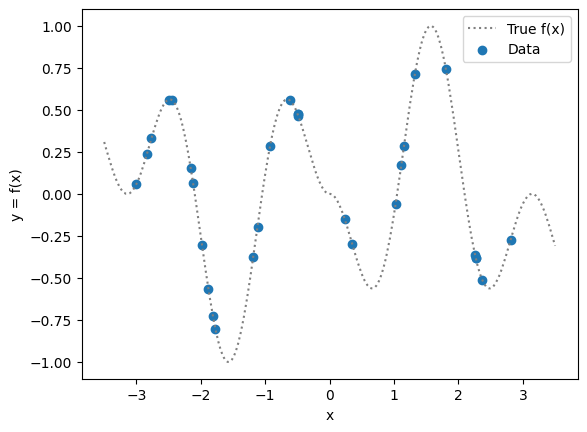

In [20]:
# Plot data
plt.scatter(data[:x], data[:f], label="Data")
plt.plot(data[:x_true], data[:f_true], c="grey", ls=":", label="True f(x)")
plt.xlabel("x")
plt.ylabel("y = f(x)")
plt.legend();

In [22]:
# Fit via ADVI. You can also use HMC.
Random.seed!(0)

m = GP(y, X, 0.0, 1.0, -2.0, 0.1)
q0 = Variational.meanfield(m)  # initialize variational distribution (optional)

# NOTE: ADVI(num_elbo_samples, max_iters)

# Compile
@time q = vi(m, ADVI(1, 1), q0, optimizer=Flux.ADAM(1e-1));

# RUN
@time q = vi(m, ADVI(1, 2000), q0, optimizer=Flux.ADAM(1e-1));

# Get posterior samples
extract_gp = make_extractor(m, q)
alpha = vec(extract_gp(:alpha));
rho = vec(extract_gp(:rho));
advi_samples = Dict(:alpha => alpha, :rho => rho)

  0.000566 seconds (558 allocations: 313.359 KiB)


[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.461029 seconds (866.89 k allocations: 600.530 MiB, 8.45% gc time)


Dict{Symbol,Array{Float64,1}} with 2 entries:
  :alpha => [0.365308, 0.330498, 0.352664, 0.294368, 0.414719, 0.436902, 0.3672…
  :rho   => [0.140713, 0.145177, 0.163187, 0.175069, 0.123828, 0.114439, 0.1807…

In [23]:
# Fit via HMC.
Random.seed!(0)
burn = 1000
nsamples = 1000

# Compile
@time _ = sample(m, HMC(0.01, 1), 1)

# Run
@time chain = sample(m, HMC(0.01, 100), burn + nsamples)

# Get posterior samples
alpha = vec(group(chain, :alpha).value.data[end-nsamples:end, :, 1]);
rho = vec(group(chain, :rho).value.data[end-nsamples:end, :, 1]);
hmc_samples = Dict(:alpha => alpha, :rho => rho)

 11.618044 seconds (30.45 M allocations: 1.523 GiB, 4.91% gc time)


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:13


 13.265527 seconds (11.43 M allocations: 28.080 GiB, 14.97% gc time)


Dict{Symbol,Array{Float64,1}} with 2 entries:
  :alpha => [0.35567, 0.369785, 0.381538, 0.37544, 0.394769, 0.429281, 0.445599…
  :rho   => [0.17294, 0.140929, 0.181402, 0.150399, 0.163229, 0.157613, 0.16641…

In [24]:
# Fit via NUTS.
Random.seed!(6)

# Compile
@time _ = sample(m, NUTS(4, 0.8), 9);

# Run
@time chain = begin
    nsamples = 1000  # number of MCMC samples
    nadapt = 1000  # number of iterations to adapt tuning parameters in NUTS
    iterations = nsamples + nadapt
    target_accept_ratio = 0.8
    
    sample(m, NUTS(nadapt, target_accept_ratio, max_depth=10), iterations);
end

# Get posterior samples
alpha = vec(group(chain, :alpha).value.data[:, :, 1]);
rho = vec(group(chain, :rho).value.data[:, :, 1]);
nuts_samples = Dict(:alpha => alpha, :rho => rho);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/ubuntu/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629


 12.850681 seconds (38.74 M allocations: 1.924 GiB, 5.31% gc time)


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/ubuntu/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.826119 seconds (1.33 M allocations: 1.411 GiB, 11.48% gc time)


In [26]:
# This funciton returns a function for predicting at new points given parameter values.
function make_gp_predict_fn(Xnew, y, X)
    N = size(X, 1)
    M = size(Xnew, 1)
    Q = N + M
    Z = [Xnew; X]
    D2 = pairwise(SqEuclidean(), Z, dims=1)
    
    return (alpha, rho) -> let
        K = sqexp_cov_fn(D2, alpha, rho, d_is_squared=true)
        Koo_inv = inv(K[(M+1):end, (M+1):end])
        Knn = K[1:M, 1:M]
        Kno = K[1:M, (M+1):end]
        C = Kno * Koo_inv
        m = C * y
        S = Matrix(LinearAlgebra.Hermitian(Knn - C * Kno'))
        mvn = MvNormal(m, S)
        rand(mvn)
    end
end

make_gp_predict_fn (generic function with 1 method)

In [27]:
# Function for plotting parameter posterior.
function plot_post(samples, name; bins=nothing, suffix="")
    param = samples[name]
    plt.hist(param, density=true, bins=bins)
    plt.xlabel(name)
    plt.ylabel("density")
    if suffix !== ""
        suffix = "($(suffix))"
    end
    plt.title("Histogram of $(name) $(suffix)");
end

plot_post (generic function with 1 method)

In [28]:
function plot_fn_posterior(samples; figsize=(12, 4), figsize_f=figsize, suffix="")
    # Get parameters
    alpha = samples[:alpha]
    rho = samples[:rho]
   
    # Plot parameters posterior.
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plot_post(samples, :alpha, bins=30, suffix=suffix)
    plt.subplot(1, 2, 2)
    plot_post(samples, :rho, bins=30, suffix=suffix)
    
    # Make predictions at new locations.
    X_new = reshape(collect(range(-3.5, 3.5, length=100)), 100, 1)
    gp_predict = make_gp_predict_fn(X_new, y, X)
    ynew = [gp_predict(alpha[m], rho[m]) for m in 1:length(alpha)]
    ynew = hcat(ynew...);

    # Summary statistics of posterior function.
    pred_mean = mean(ynew, dims=2)
    pred_lower = quantiles(ynew, 0.025, dims=2)
    pred_upper = quantiles(ynew, 0.975, dims=2)
    
    if suffix !== ""
        suffix = "($(suffix))"
    end 
     
    # Plot predictions.
    plt.figure(figsize=figsize_f)
    plt.plot(vec(X_new), vec(pred_mean), color="blue", label="Posterior predictive mean")
    plt.plot(data[:x_true], data[:f_true], color="black", ls=":", label="True f(x)")
    plt.scatter(vec(X), vec(y), color="grey", label="Data")
    plt.fill_between(vec(X_new), vec(pred_upper), vec(pred_lower), color="blue", alpha=0.1)
    plt.legend(loc="upper left")
    plt.title("GP Posterior predictive with 95% credible interval $(suffix)");
end

plot_fn_posterior (generic function with 1 method)

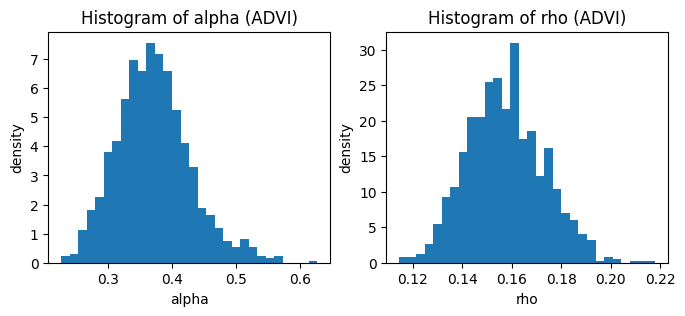

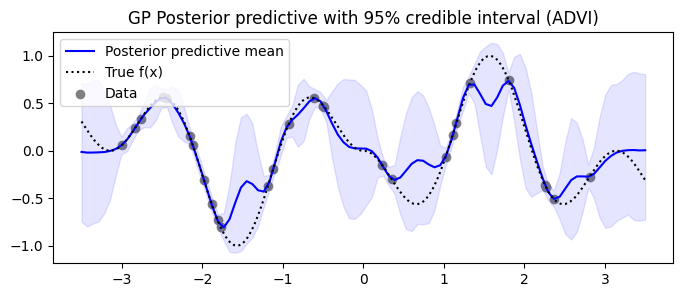

In [29]:
plot_fn_posterior(advi_samples, figsize=(8, 3), suffix="ADVI");

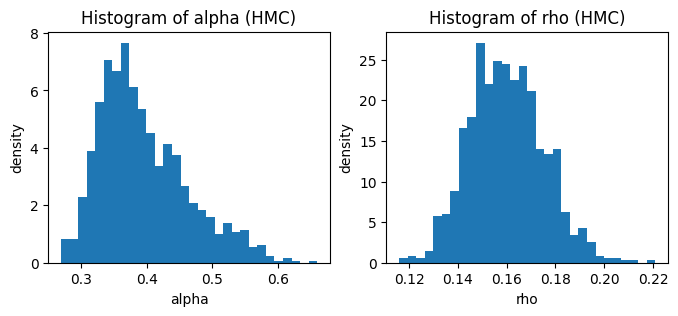

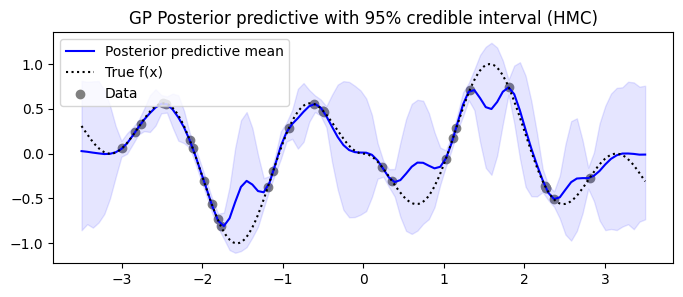

In [30]:
plot_fn_posterior(hmc_samples, figsize=(8, 3), suffix="HMC");

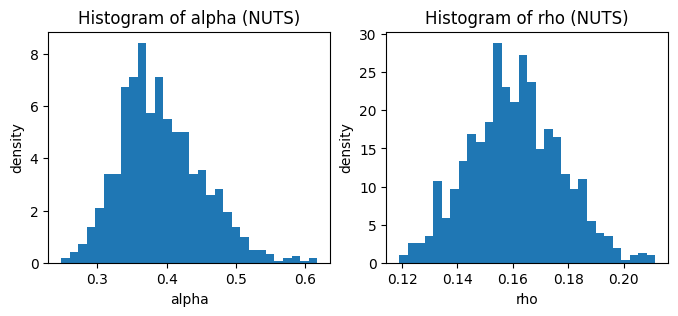

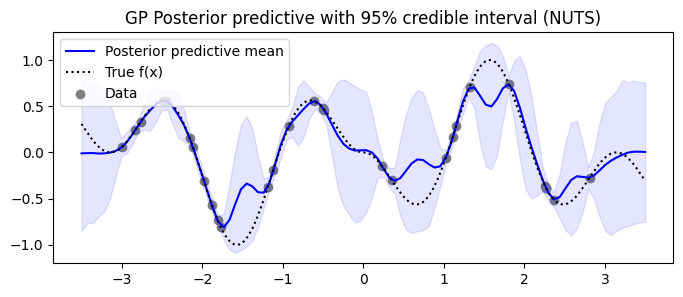

In [31]:
plot_fn_posterior(nuts_samples, figsize=(8, 3), suffix="NUTS");